In [7]:
from lvmtipo.actors import lvm
from lvmagp.actor.statemachine import ActorState, ActorStateMachine
from lvmagp.guide.worker import GuiderWorker

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def plot(image, ref_image):
    fig,ax1 = plt.subplots(figsize=(8, 4.5))
    ax1.imshow(image.data,norm=LogNorm(vmin=50, vmax=500))
    ax1.plot(image.catalog["x"],image.catalog["y"],"o",markerfacecolor="none",markeredgecolor="r",ms=20)
    ax1.plot(ref_image.catalog["x"],ref_image.catalog["y"],"o",markerfacecolor="none",markeredgecolor="w",ms=16)
    plt.show()


In [19]:
from logging import DEBUG, INFO
from sdsstools import get_logger
from sdsstools.logger import SDSSLogger
from sdsstools.logger import StreamFormatter
from astropy.coordinates import SkyCoord, Angle

from IPython.display import display, clear_output

from lvmagp.json_serializers import serialize_skycoord
import pandas as pd
import json
from pandas import json_normalize


log = get_logger("guiding")
log.setLevel(DEBUG)
log.sh.formatter = StreamFormatter(fmt='%(asctime)s %(name)s %(levelname)s %(filename)s:%(lineno)d: \033[1m%(message)s\033[21m')

tel = lvm.sci
await tel.start()
await tel.foc.status()

statemachine = ActorStateMachine()
worker = GuiderWorker(tel, statemachine, logger=log)
worker.logger.sh.setLevel(DEBUG)
statemachine.state

#log.debug("test")

<ActorState.IDLE: 'IDLE'>

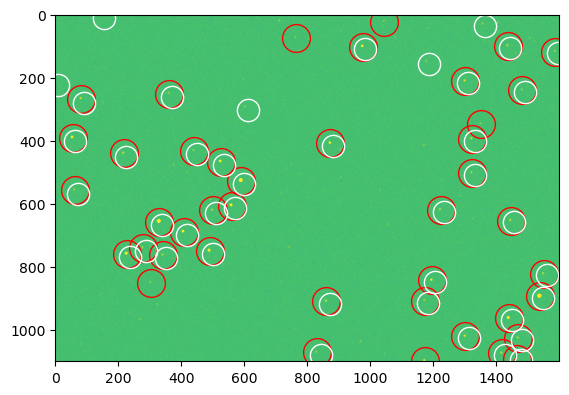

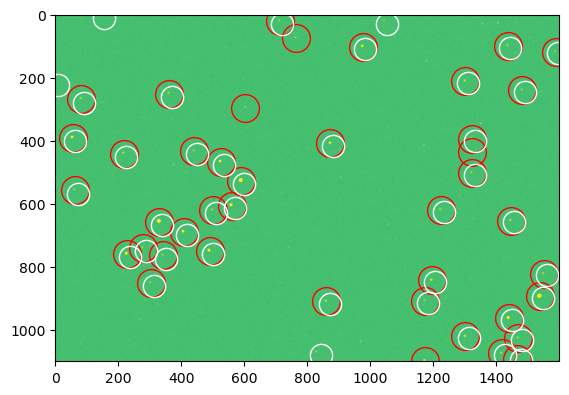

{'isreference': False, 'state': 'GUIDE', 'filenames': ['/data/lvm/sci/agcam/east/20230309/lvm.sci.agcam.east_00000406.fits', '/data/lvm/sci/agcam/west/20230309/lvm.sci.agcam.west_00000406.fits'], 'catalog': ['{"x":{"0":1538.1412850955,"1":329.8485427526,"2":589.9846198731,"3":489.4249584968,"4":1439.3165986442,"5":226.6717409376,"6":559.3397395472,"7":406.7750975015,"8":54.402511849,"9":524.8504799502,"10":975.91009239,"11":872.9451472766,"12":1172.7521374527,"13":1195.3057882303,"14":1464.8926593778,"15":1301.2078650905,"16":1322.3287608529,"17":1300.6794189915,"18":1445.7081877879,"19":81.7280630155,"20":216.798394206,"21":860.3267713147,"22":1469.3688530149,"23":499.00876685,"24":1416.9225312769,"25":1322.2152313908,"26":1436.5550660098,"27":1549.8203644748,"28":1222.7072831257,"29":440.4159158085,"30":342.0589954007,"31":61.6695258162,"32":361.1638258397,"33":277.9534378016,"34":1482.0395481583,"35":1172.7479359793,"36":829.8042683501,"37":1587.635395019,"38":302.6215471445,"39":10

DEBUG:lvmagp.guide.offset.pwi:radec: 3.63813420158803 -14.636244617184902
DEBUG:lvmagp.guide.offset.pwi:axis: 10.148696709327965 deg 11.3202130990814 deg
DEBUG:lvmagp.guide.offset.pwi:correct axis: 8.118957367462372 9.05617047926512


CancelledError: 

In [23]:
reference_images = None

async def callback(is_reference:bool, state:ActorState, filenames:list, images:list, position:SkyCoord, correction:list=None):
    global reference_images
    status = {"isreference": is_reference,
              "state": state.name,
              "filenames": filenames,
              "catalog": [img.catalog.to_pandas().to_json() for img in images],
              "position": serialize_skycoord(position)
             }
    if not is_reference:
        status.update(**correction)
        clear_output(wait=True)
    else:
        reference_images = images

    for idx, img in enumerate(images):
        plot(img, reference_images[idx] if reference_images else img)

    print(status)

await worker.work(callback=callback)